# train_hyperasの確認

In [1]:
import numpy as np
import pandas as pd
#最大表示列数の指定
pd.set_option('display.max_columns', 300)

%matplotlib inline 
import matplotlib.pyplot as plt

plt.style.use('ggplot') 

In [2]:
race_df = pd.read_csv("./csv/cleaned_race_data.csv", sep=",")
horse_df = pd.read_csv("./csv/cleaned_horse_data.csv", sep=",")

/home/naokiuno634/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
#predict_result = pd.read_csv("./predict/train_simple_predicted_test.csv", sep=",")
predict_result = pd.read_csv("./predict/train_hyperas_predicted_test.csv", sep=",")

In [46]:
# 障害レースは取り除く
predict_result = predict_result[predict_result["is_obstacle"]==0]

In [47]:
predict_result.head()

,race_id,frame_number,horse_number,age,burden_weight,horse_weight,date,is_senba,is_mesu,is_osu,distance,horse_weight_dif,burden_weight_rate,ground_status,total_horse_number,is_obstacle,weather_rain,weather_snow,weather_小雨,weather_小雪,weather_晴,weather_曇,weather_雨,weather_雪,where_racecourse_中京,where_racecourse_中山,where_racecourse_京都,where_racecourse_函館,where_racecourse_小倉,where_racecourse_新潟,where_racecourse_札幌,where_racecourse_東京,where_racecourse_福島,where_racecourse_阪神,ground_type_ダ,ground_type_芝,is_left_right_straight_右,is_left_right_straight_左,is_left_right_straight_直線,pre_date_diff,is_rider_same,is_tamer_same,is_owner_same,rank_1,frame_number_1,horse_number_1,age_1,burden_weight_1,goal_time_1,half_way_rank_1,last_time_1,odds_1,popular_1,horse_weight_1,is_down_1,distance_1,avg_velocity_1,horse_weight_dif_1,burden_weight_rate_1,ground_status_1,total_horse_number_1,is_obstacle_1,weather_rain_1,weather_snow_1,weather_小雨_1,weather_小雪_1,weather_晴_1,weather_曇_1,weather_雨_1,weather_雪_1,where_racecourse_中京_1,where_racecourse_中山_1,where_racecourse_京都_1,where_racecourse_函館_1,where_racecourse_小倉_1,where_racecourse_新潟_1,where_racecourse_札幌_1,where_racecourse_東京_1,where_racecourse_福島_1,where_racecourse_阪神_1,ground_type_ダ_1,ground_type_芝_1,is_left_right_straight_右_1,is_left_right_straight_左_1,is_left_right_straight_直線_1,pre_date_diff_1,is_rider_same_1,is_tamer_same_1,is_owner_same_1,interval_date_1,rank_2,frame_number_2,horse_number_2,age_2,burden_weight_2,goal_time_2,half_way_rank_2,last_time_2,odds_2,popular_2,horse_weight_2,is_down_2,distance_2,avg_velocity_2,horse_weight_dif_2,burden_weight_rate_2,ground_status_2,total_horse_number_2,is_obstacle_2,weather_rain_2,weather_snow_2,weather_小雨_2,weather_小雪_2,weather_晴_2,weather_曇_2,weather_雨_2,weather_雪_2,where_racecourse_中京_2,where_racecourse_中山_2,where_racecourse_京都_2,where_racecourse_函館_2,where_racecourse_小倉_2,where_racecourse_新潟_2,where_racecourse_札幌_2,where_racecourse_東京_2,where_racecourse_福島_2,where_racecourse_阪神_2,ground_type_ダ_2,ground_type_芝_2,is_left_right_straight_右_2,is_left_right_straight_左_2,is_left_right_straight_直線_2,pre_date_diff_2,is_rider_same_2,is_tamer_same_2,is_owner_same_2,interval_date_2,rank_3,frame_number_3,horse_number_3,age_3,burden_weight_3,goal_time_3,half_way_rank_3,last_time_3,odds_3,popular_3,horse_weight_3,is_down_3,distance_3,avg_velocity_3,horse_weight_dif_3,burden_weight_rate_3,ground_status_3,total_horse_number_3,is_obstacle_3,weather_rain_3,weather_snow_3,weather_小雨_3,weather_小雪_3,weather_晴_3,weather_曇_3,weather_雨_3,weather_雪_3,where_racecourse_中京_3,where_racecourse_中山_3,where_racecourse_京都_3,where_racecourse_函館_3,where_racecourse_小倉_3,where_racecourse_新潟_3,where_racecourse_札幌_3,where_racecourse_東京_3,where_racecourse_福島_3,where_racecourse_阪神_3,ground_type_ダ_3,ground_type_芝_3,is_left_right_straight_右_3,is_left_right_straight_左_3,is_left_right_straight_直線_3,pre_date_diff_3,is_rider_same_3,is_tamer_same_3,is_owner_same_3,interval_date_3,rank_4,frame_number_4,horse_number_4,age_4,burden_weight_4,goal_time_4,half_way_rank_4,last_time_4,odds_4,popular_4,horse_weight_4,is_down_4,distance_4,avg_velocity_4,horse_weight_dif_4,burden_weight_rate_4,ground_status_4,total_horse_number_4,is_obstacle_4,weather_rain_4,weather_snow_4,weather_小雨_4,weather_小雪_4,weather_晴_4,weather_曇_4,weather_雨_4,weather_雪_4,where_racecourse_中京_4,where_racecourse_中山_4,where_racecourse_京都_4,where_racecourse_函館_4,where_racecourse_小倉_4,where_racecourse_新潟_4,where_racecourse_札幌_4,where_racecourse_東京_4,where_racecourse_福島_4,where_racecourse_阪神_4,ground_type_ダ_4,ground_type_芝_4,is_left_right_straight_右_4,is_left_right_straight_左_4,is_left_right_straight_直線_4,pre_date_diff_4,is_rider_same_4,is_tamer_same_4,is_owner_same_4,interval_date_4,rank_5,frame_number_5,horse_number_5,age_5,burden_weight_5,goal_time_5,half_way_rank_5,last_time_5,odds_5,popular_5,horse_weight_5,is_down_5,distance_5,avg_velocity_5,horse_weight_dif_5,burden_weight_rate_5,ground_status_5,total_horse_number_5,is_obstacle_5,weath

In [48]:
# 予測値を100倍して見やすくする
predict_result["predict_is_tansyo"] = predict_result["predict_is_tansyo"]*100
predict_result["predict_is_hukusyo"] = predict_result["predict_is_hukusyo"]*100

In [49]:
predict_result.shape

(83088, 282)

## accuracy の計算
groupbyして、レースごとに確率の最も高い馬を見つける。
正解していたかを判定

In [50]:
# group by したデータフレームに対して行う処理
def check_is_correct_predict_is_tansyo(one_race_data):
    return one_race_data.loc[one_race_data['predict_is_tansyo'].idxmax()]['is_tansyo']
def check_is_correct_predict_is_hukusyo(one_race_data):
    return one_race_data.loc[one_race_data['predict_is_hukusyo'].idxmax()]['is_hukusyo']

In [51]:
part_predict_result = predict_result[["race_id","date","horse_number","predict_is_hukusyo", "is_hukusyo","predict_is_tansyo", "is_tansyo"]]

is_tansyo = part_predict_result.groupby('race_id').apply(check_is_correct_predict_is_tansyo)
is_hukusyo = part_predict_result.groupby('race_id').apply(check_is_correct_predict_is_hukusyo)
print("tansyo accuracy: {}".format(is_tansyo.sum()/is_tansyo.size))
print("hukusyo accuracy: {}".format(is_hukusyo.sum()/is_hukusyo.size))

tansyo accuracy: 0.23528439153439154
hukusyo accuracy: 0.5403439153439153


# blending
お互いの欠点を補い合えるかも...？

In [52]:
blend_df = predict_result.copy()
blend_df["blend"] = 0.5*blend_df["predict_is_tansyo"] + 0.5*blend_df["predict_is_hukusyo"]
blend_df = blend_df[["race_id","date","horse_number", "blend","is_hukusyo", "is_tansyo"]]

def blend_check_is_correct_predict_is_tansyo(one_race_data):
    return one_race_data.loc[one_race_data['blend'].idxmax()]['is_tansyo']
def blend_check_is_correct_predict_is_hukusyo(one_race_data):
    return one_race_data.loc[one_race_data['blend'].idxmax()]['is_hukusyo']

is_tansyo = blend_df.groupby('race_id').apply(blend_check_is_correct_predict_is_tansyo)
is_hukusyo = blend_df.groupby('race_id').apply(blend_check_is_correct_predict_is_hukusyo)
print("tansyo accuracy: {}".format(is_tansyo.sum()/is_tansyo.size))
print("hukusyo accuracy: {}".format(is_hukusyo.sum()/is_hukusyo.size))

tansyo accuracy: 0.24503968253968253
hukusyo accuracy: 0.5434854497354498


## 同着の試合があるかもしれないので取り除く
同着はデータがおかしくなっているので取り除く。
また、10頭以下のレースは取り除く

In [10]:
merged_df = pd.merge(blend_df, race_df, on="race_id")
merged_df = pd.merge(merged_df, horse_df, on=['race_id','horse_number'])
merged_df['tansyo_return'] = merged_df['is_tansyo']*merged_df['tansyo'] - 100
merged_df["hukusyo_return"] = (merged_df["rank"]==1)*merged_df["hukusyo_first"] + (merged_df["rank"]==2)*merged_df["hukusyo_second"] + (merged_df["rank"]==3)*merged_df["hukusyo_third"]  - 100

In [11]:
def remove_same(one_horse_data):
    #  数レース分の情報を結合
    result_df = one_horse_data.copy()
    
    if result_df["rank"].duplicated().sum() or result_df["total_horse_number"].iloc[0]<10:
        return 
    else:
        return result_df

In [12]:
print(merged_df.shape)
removed = merged_df.groupby("race_id").apply(remove_same)
print(removed.shape)

(86667, 61)
(78575, 61)


## 可視化

In [13]:
removed = removed.reset_index(drop=True)
removed.head()

,race_id,date_x,horse_number,blend,is_hukusyo,is_tansyo,race_round,weather,ground_status,date_y,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,is_obstacle,ground_type,is_left_right_straight,distance_x,weather_rain,weather_snow,rank,frame_number,horse_id,age,burden_weight,rider_id,goal_time,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,date,is_down,is_senba,is_mesu,is_osu,distance_y,avg_velocity,horse_weight_dif,burden_weight_rate,tansyo_return,hukusyo_return
0,201701010103,2017-07-29 10:45:00,5.0,24.852316,1,0,3,晴,1,2017-07-29 10:45:00,札幌,12,3,3,5,5,6,8,580,160,240,110,1260,3310,1040,290,530,4750,2110,16870,0.0,ダ,右,2400,0,0,2,5,2014100615,3,56.0,1025,155.7,5.00,38.0,13.9,7.0,484.0,1017,788800,2017-07-29 10:45:00,0,0,0,1,2400,15.414258,-12.0,0.115702,-100,140
1,201701010103,2017-07-29 10:45:00,10.0,8.882791,0,0,3,晴,1,2017-07-29 10:45:00,札幌,12,3,3,5,5,6,8,580,160,240,110,1260,3310,1040,290,530,4750,2110,16870,0.0,ダ,右,2400,0,0,9,7,2014103515,3,55.0,1152,158.2,9.75,39.9,117.8,10.0,460.0,1041,789006,2017-07-29 10:45:00,0,0,0,1,2400,15.170670,-2.0,0.119565,-100,-100
2,201701010103,2017-07-29 10:45:00,7.0,2.677181,0,0,3,晴,1,2017-07-29 10:45:00,札幌,12,3,3,5,5,6,8,580,160,240,110,1260,3310,1040,290,530,4750,2110,16870,0.0,ダ,右,2400,0,0,11,6,2014100822,3,53.0,1147,159.1,6.00,41.1,185.0,11.0,436.0,1068,547800,2017-07-29 10:45:00,0,0,1,0,2400,15.084852,-8.0,0.121560,-100,-100
3,201701010103,2017-07-29 10:45:00,4.0,20.522037,0,0,3,晴,1,2017-07-29 10:45:00,札幌,12,3,3,5,5,6,8,580,160,240,110,1260,3310,1040,290,530,4750,2110,16870,0.0,ダ,右,2400,0,0,6,4,2014101963,3,56.0,1109,157.0,5.00,40.0,7.7,4.0,454.0,1119,593006,2017-07-29 10:45:00,0,0,0,1,2400,15.286624,-4.0,0.123348,-100,-100
4,201701010103,2017-07-29 10:45:00,6.0,29.982492,0,0,3,晴,1,2017-07-29 10:45:00,札幌,12,3,3,5,5,6,8,580,160,240,110,1260,3310,1040,290,530,4750,2110,16870,0.0,ダ,右,2400,0,0,7,5,2014109102,3,56.0,1093,157.6,2.25,40.4,6.0,3.0,502.0,1026,75800,2017-07-29 10:45:00,0,0,0,1,2400,15.228426,-8.0,0.111554,-100,-100


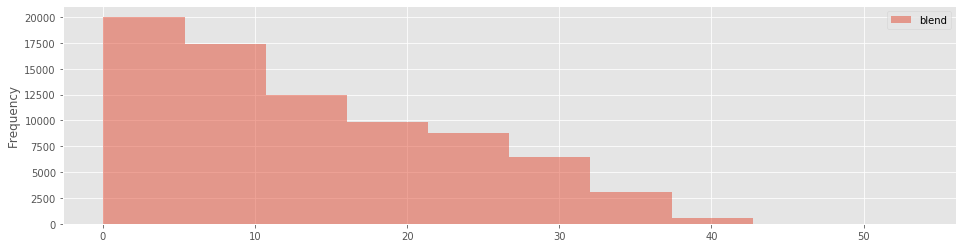

In [14]:
# blendの分布についてヒストグラム
removed.plot(kind='hist', y='blend' , bins=10, figsize=(16,4), alpha=0.5)

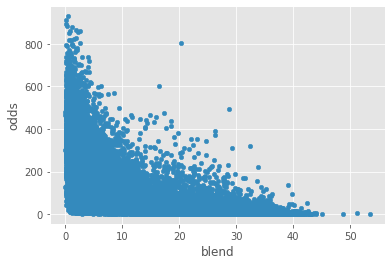

In [15]:
# オッズと予測値
removed.plot(kind='scatter', x='blend', y='odds')

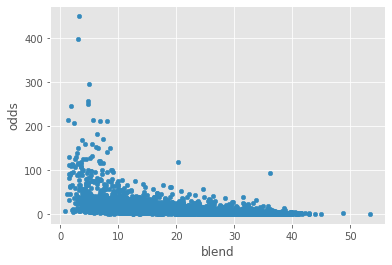

In [16]:
# 実際に1位になったものについてのオッズと予測値
removed[removed["rank"]==1].plot(kind='scatter', x='blend', y='odds')

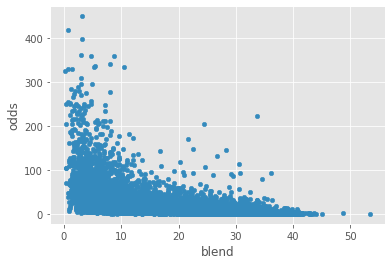

In [17]:
# 実際に複勝圏内になったものについてのオッズと予測値
removed[removed["rank"]<=3].plot(kind='scatter', x='blend', y='odds')

## 的中率の計算(実際に1位や３位以内であった確率）

In [18]:
# cut
removed["blend_cut"] = pd.cut(removed["blend"], 10)

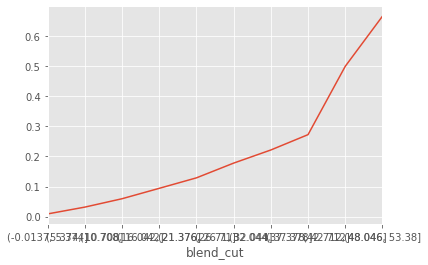

In [19]:
# tansyo
def right_rate_tansyo(one_cut):
    return one_cut["is_tansyo"].sum()/len(one_cut)
    
removed.groupby("blend_cut").apply(right_rate_tansyo).plot()

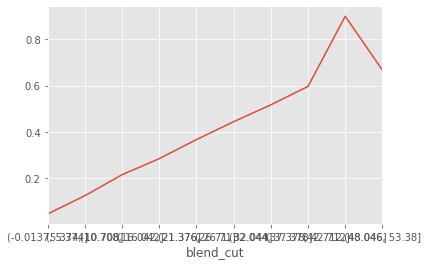

In [20]:
# hukusyo
def right_rate_hukusyo(one_cut):
    return one_cut["is_hukusyo"].sum()/len(one_cut)
    
removed.groupby("blend_cut").apply(right_rate_hukusyo).plot()

## 回収率の計算

In [21]:
def get_return(one_race):
    tmp = one_race.reset_index()
    return tmp.loc[tmp['blend'].idxmax(),['tansyo_return','hukusyo_return','odds','date','blend']]

race_result = removed.groupby("race_id").apply(get_return)

In [22]:
race_result = race_result.sort_values("date")

In [23]:
race_result = race_result.set_index("date")

### 単勝

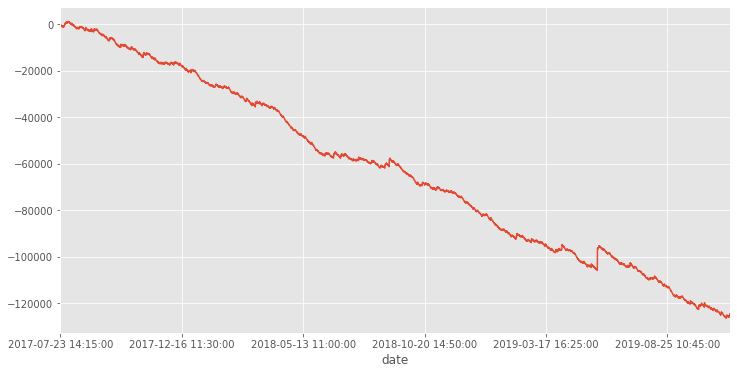

In [54]:
# 単純に買い続けたとき
simple = race_result["tansyo_return"].cumsum()
simple.plot(figsize=(12, 6))

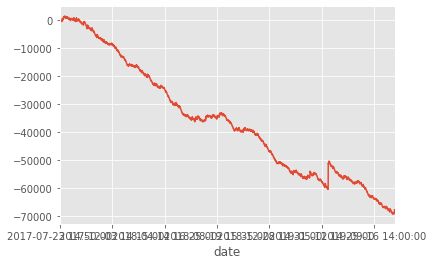

In [25]:
# breandがある程度あるときだけ
simple = race_result.loc[(race_result["blend"]>30), 'tansyo_return'].cumsum()
simple.plot()

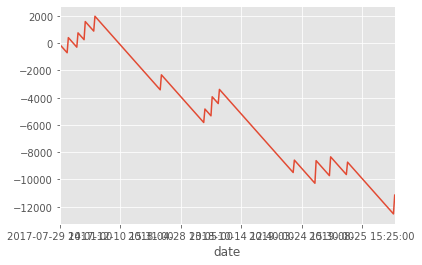

In [26]:
# オッズがある範囲のとき
simple = race_result.loc[((race_result["odds"]>10) & (race_result["odds"]<60) & (race_result["blend"]>30)), 'tansyo_return'].cumsum()
simple.plot()

### 複勝

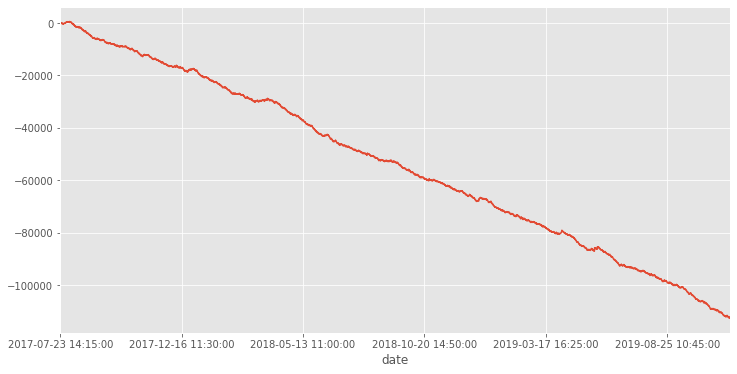

In [55]:
# 単純に買い続けたとき
simple = race_result["hukusyo_return"].cumsum()
simple.plot(figsize=(12, 6))

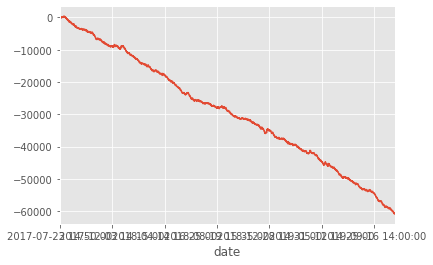

In [28]:
# blendの予測値を含める
simple = race_result.loc[(race_result["blend"]>30), 'hukusyo_return'].cumsum()
simple.plot()

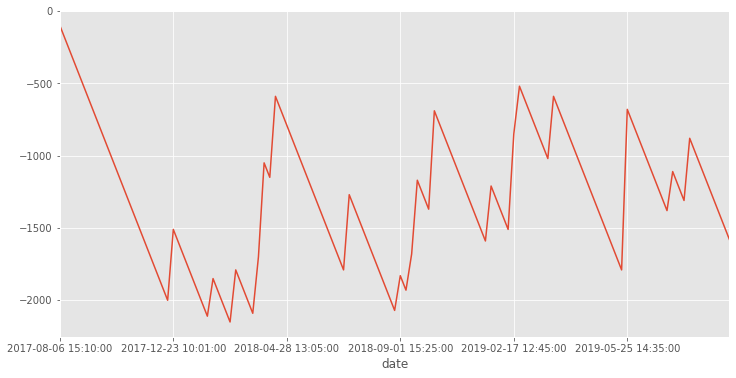

In [53]:
# オッズがある範囲のとき
simple = race_result.loc[((race_result["odds"]>20.0) & (race_result["odds"]<65)), 'hukusyo_return'].cumsum()
simple.plot(figsize=(12, 6))